# MLCommons Earthquake GPU Analysis Notebook
- Creates Pickle file with data for all available runs
- Generates GPU Events Graphs
- Generates GPU Power Usage Graphs

In [4]:
import os
import re
import glob
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.dates as md
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [10, 7]

## TODO
- Make paths smarter ex. if 'card_name_' in dir save there, else higher level
- Add NNSE stuff
- Create total time plots
- Do data analysis for just training time
- take advantage of run_info dict

### Data Extraction Functions

In [5]:
def format_gpu_log(path):
    """ Format the gpu data log into dataframe.

    Args:
        path: file path for the gpu log.
    Returns:
        dataframe with gpu data.
    """
    # read in data
    gpu_df = pd.read_csv(path, skiprows=1,header=None,low_memory=False)
    
    # get headers
    header = gpu_df.loc[0]
    header = header.str[2:].str.strip()
    gpu_df = gpu_df.drop(index = [0]).reset_index(drop=True)
    gpu_df= gpu_df.set_axis(header,axis=1,inplace=False)
    
    # set types
    int_col = list(gpu_df.columns[1:-1])
    gpu_df[int_col] = gpu_df[int_col].astype('int')
    float_col = list(gpu_df.columns[-1:])
    gpu_df[float_col] = gpu_df[float_col].astype('float')
    time_col = list(gpu_df.columns[:1])[0]

    gpu_df = gpu_df.groupby('time').mean().reset_index()
    
    return gpu_df

In [6]:
def get_timer_data(err_path):
    """ Collect timer data from run output and create dataframe and csv.

    Args:
        path: file path for the run log.
    Returns:
        dataframe with timer data.
    """   
    def index_containing_substring(the_list, substring, _not=False):
        index = []
        for i, s in enumerate(the_list):
            if not _not:
                if substring in s:
                    index.append(i)
            else:
                if substring not in s:
                    index.append(i)
        if _not:
            return index
        elif substring == '# csv,RUN_STOP':
            if len(index) < 2:
                return -1
            return index[-2] + 1
        elif not index is None:
            return index[-1]
        return -1    

    directory = err_path.rsplit("/",1)[0]
    output_path = os.path.join(directory,'timer.csv')
    
    # read in data
    with open(err_path) as f:
        content = f.readlines()
    
    # get timer content
    start = index_containing_substring(content, '# csv,timer,status,time,sum,start,tag,msg,uname.node,user,uname.system,platform.version')
    stop = index_containing_substring(content, '# csv,RUN_STOP')
    if stop == -1:
        print(f'Incomplete Run: {directory}')
        return None
    content = content[start:stop]
    neg = index_containing_substring(content, '# csv', _not=True)
    
    # fix for dictionary in csv
    fixed = ''.join(content[min(neg):max(neg)+1]).strip().replace('\n','').replace('\s+','').replace('\t+','')
    for x in range(min(neg),max(neg)+1):
        content.pop(min(neg))

    # formatting
    times = []
    for x in content:
        times.append(x.strip('\n').replace('# csv,',''))
    times[min(neg)-1] = times[min(neg)-1]+fixed
    data = []
    for x in times:
        x = re.sub("\{[^}]*\}", lambda x:x.group(0).replace(',',';'), x)
        data.append(x)
    
    # save off data
    pd.DataFrame(data)[0].str.split(',', expand=True).to_csv(output_path, index=False)
    df = pd.read_csv(output_path, header=1, sep=',', engine='python')

    # convert to datetime
    df['start'] = pd.to_datetime(df['start'], format='%Y-%m-%d %H:%M:%S')
    df = df[df['status'] != 'failed']
    
    # get end time
    for i, row in df.iterrows():
        df.loc[i,'end'] = row['start'] + datetime.timedelta(seconds=float(row.time))

    return df

In [7]:
def get_power_data(data_dict):
    """ Convert gpu dataframe into data for plots.
    Args:
        data_dict: dictionary of run data. 
    Returns:
        dataframe with power data.
    """   
    # setup
    data = {}
    rename = {
        '# time': 'time',
        'id': 'id',
        'gpu_util %': 'gpu_util',
        'memory_util %': 'memory_util',
        'encoder_util %': 'encoder_util',
        'decoder_util %': 'decoder_util',
        'gpu_temp C': 'gpu_temp',
        'power_draw W': 'power_draw'
    }
    
    # collect run info
    data['gpu'] = data_dict['run_info']['gpu']
    data['numGpus'] = data_dict['run_info']['numGpus']
    data['numCpus'] = data_dict['run_info']['numCpus']
    data['mem'] = data_dict['run_info']['mem']
    data['epochs'] = data_dict['run_info']['epochs']
    
    # build power data total notebook
    gpu_df = data_dict['gpu_df'].rename(columns=rename)
    grouped = gpu_df.groupby(['time']).mean()['power_draw'].reset_index()       
    data['kWh_total'] = sum(grouped['power_draw'])*(1/3600)*(1/1000)
    data = pd.DataFrame([data], columns=data.keys())
    
    # build power data model fit
    timer_df = data_dict['timer_df']
    delta = min(timer_df['start']) - min(grouped['time']).round('1h')
    fit_event = timer_df.loc[timer_df['timer'] == 'RunTFTCustomVersion train']
    fit_start = fit_event['start'] - delta
    fit_end = fit_event['end'] - delta
    fit_grouped = grouped[(grouped['time'] >= fit_start.values[0]) & (grouped['time'] <= fit_end.values[0])]
    data['kWh_fit'] = sum(fit_grouped['power_draw'])*(1/3600)*(1/1000)
    
    return data

In [8]:
def get_NNSE_data(err_path):
    with open(err_path) as f:
        lines = f.readlines()
    NNSE_lines = []
    for line in lines:
        if 'NNSE \n' in line:
            line = line.replace("\n", "").strip()
            NNSE_lines.append(line)
            num = 5
        elif num != 0:
            NNSE_clean = NNSE.replace("\n", "").strip()
            lis.append(NNSE_clean)
            num -= 1
            if num == 0:
                full_lis.append(lis)
                lis = []
    import pdb; pdb.set_trace()
    return -1

### Plotting Functions

In [9]:
# formatting dictionary for event plot
timers_dict = {
 'EVAL':{
     'hatch':None, 
     'facecolor':"none", 
     'edgecolor':None,'rename':None, 
     'color':'tab:blue', 
     'alpha':0.15
 },
 'CELL_READ_DATA':{
     'hatch':'//',
     'facecolor':"none",
     'edgecolor':'black',
     'rename':None,
     'color':None,
     'alpha':0.7
 },
 'data head setup':{
     'hatch':None, 
     'facecolor':"none", 
     'edgecolor':None,
     'rename':None,
     'color':'tab:green',
     'alpha':0.15
 },
 'legal sampling location':{
     'hatch':'\\\\', 
     'facecolor':"none",
     'edgecolor':'black',
     'rename':None,
     'color':None,
     'alpha':0.7
 },
 'RunTFTCustomVersion bestfit finalize TFTTestpredict':{
     'hatch':None, 
     'facecolor':"none", 
     'edgecolor':None,
     'rename':'TFTTestpredict',
     'color':'tab:cyan',
     'alpha':0.15
 },
 'RunTFTCustomVersion bestfit finalize VisualizeTFT TFTSaveandInterpret setFFFFmapping':{
     'hatch':None,
     'facecolor':"none",
     'edgecolor':None,
     'rename':'setFFFFmapping',
     'color':'tab:purple',
     'alpha':0.15
 },
 'RunTFTCustomVersion bestfit finalize VisualizeTFT DLprediction':{
     'hatch':None,
     'facecolor':"none",
     'edgecolor':None,
     'rename':'DLprediction',
     'color':'tab:orange',
     'alpha':0.15
 },
 'DLResults_Graphs':{
     'hatch':None,
     'facecolor':"none",
     'edgecolor':None,
     'rename':'DLResults_Graphs',
     'color':'tab:olive',
     'alpha':0.15
 }
}

In [49]:
def plot_gpu_events(timer_df, gpu_df, epochs, name, path, zoom=False):
    """ Create gpu events plot and save figure.
    Args:
        timer_df: timer dataframe. 
        gpu_df: gpu log dataframe.
        epochs: number of epochs.
        name: run name.
        path: output path.
        zoom: optional arg for zooming on event
    """   
    # initialize
    event_times_dir = os.path.join(path,'event_times')
    if not zoom == False:
        name = f'{name}_zoomed_{zoom}'
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)

    # get epoch data
    num_epochs = int(epochs)
    epoch_timers = []
    for epoch in range(num_epochs):
        epoch_times = [x for x in timer_df['timer'] if f'Epoch:{epoch}' in x]
        end_time = max(timer_df[timer_df['timer'].isin(epoch_times)]['end'])
        timer_df.loc[timer_df['timer'] == f'RunTFTCustomVersion train Epoch:{epoch}', 'end'] = end_time
        timer_df.loc[timer_df['timer'] == f'RunTFTCustomVersion train Epoch:{epoch}', 'timer'] = f'Epoch:{epoch}'
        epoch_timers.append(f'Epoch:{epoch}')
    epoch_alpha = 0.2
    alpha_inc = (0.7)/num_epochs
    
    # select columns of interest    
    timers = list(timers_dict.keys()) + epoch_timers
    event_df = timer_df[timer_df['timer'].isin(timers)]
    
    # find time delta
    delta = min(event_df['start']) - min(gpu_df.reset_index()['time'])

    # create plot of each event
    ax.plot(gpu_df['time'], gpu_df['power_draw W'], color='black', linewidth=0.75)
    for i, row in event_df.iterrows():
        start_time = row['start'] - delta.round('1h')
        end_time = row['end'] - delta.round('1h')
        if 'Epoch:' in row['timer']:
            ax.axvspan(start_time, end_time,
                        alpha=epoch_alpha,
                        label=row['timer'],
                        color='tab:red')
            epoch_alpha += alpha_inc
        else:
            timer_style = timers_dict[row['timer']]
            if timer_style['rename'] is not None:
                row['timer'] = timer_style['rename']
            if zoom == False:
                label= row['timer']
            else:
                label = '_nolegend_'
            ax.axvspan(start_time, end_time, 
                        alpha=timer_style['alpha'], label=label, 
                        hatch=timer_style['hatch'], facecolor=timer_style['facecolor'], 
                        edgecolor=timer_style['edgecolor'], 
                        color=timer_style['color'])
    # annotations
    annotation_epoch = num_epochs-2
    sample = timer_df[timer_df['timer'] == f'RunTFTCustomVersion validation bestfit Epoch:{annotation_epoch}']
    annotation_height = 1.13
    start_time = sample['start'] - delta.round('1h')
    end_time = sample['end'] - delta.round('1h')
    filtered = gpu_df[(gpu_df['time'] >= start_time.values[0]) & (gpu_df['time'] <= end_time.values[0])]
    watts = filtered.loc[filtered['power_draw W'].idxmax()]['power_draw W']
    time = filtered.loc[filtered['power_draw W'].idxmax()]['time']
    
    # make annotations zoom dependent
    if zoom == False:
        plt.annotate('validation/bestfit', 
                     xy=(time,watts), 
                     xytext=(time+timedelta(hours=1), max(gpu_df['power_draw W'])*annotation_height),
                     xycoords='data',
                     horizontalalignment="left", verticalalignment='center',
                     #connectionstyle='angle,angleA=-90,angleB=10,rad=5'
                     arrowprops=dict(arrowstyle='->',lw=1, connectionstyle="arc,angleB=70,armA=0,armB=20"))
    elif zoom == 'validation':
        row = timer_df.loc[timer_df['timer'] == f'RunTFTCustomVersion validation bestfit Epoch:{annotation_epoch}']
        start_time = row['start'] - delta.round('1h')
        end_time = row['end'] - delta.round('1h')
        ax.axvspan(start_time, end_time, 
                    alpha=0.5, label='Validation', 
                    hatch='////', facecolor='none',
                    edgecolor='black',
                    color=None)
        ax.set_xlim([start_time - timedelta(minutes=3.5) ,end_time + timedelta(minutes=3.5)])
    elif zoom == 'DLResults':
        row = timer_df.loc[timer_df['timer'] == 'DLResults_Graphs']
        start_time = row['start'] - delta.round('1h')
        end_time = row['end'] - delta.round('1h')
        ax.set_xlim([start_time - timedelta(minutes=3.5) ,end_time + timedelta(minutes=0.5)])
    
    # plot formatting
    plt.title(f'{name} Event Times')  
    ax.set_ylabel(f'Watts')
    ax.set_xlabel(f'Execution Time (Hours)')
    ax.set_ylim(0,max(gpu_df['power_draw W'])*1.25)
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 30]))
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
    plt.gcf().autofmt_xdate()
    plt.show()
    
    # save figure
    if not os.path.exists(event_times_dir):
        os.mkdir(event_times_dir)
    save_name = os.path.join(event_times_dir,f'{name}.png')
    fig.savefig(save_name, bbox_inches='tight')

In [11]:
def plot_power_usage(df, path):
    """ Create power usage plot and save figure.
    Args:
        df: power dataframe. 
        path: output path.
    """
    power_usage_dir = os.path.join(path,'power_usage')
    name = path.rsplit('/',1)[1]
    if not os.path.exists(power_usage_dir):
        os.mkdir(power_usage_dir)
    df['epochs'] = df['epochs'].astype(int)
    df.sort_values('epochs')   
    plt.rcParams['figure.figsize'] = [10, 5]
    
    # plot total notebook epochs vs. kWh
    sns.barplot(x='epochs', y='kWh_total', hue='gpu',data=df) 
    plt.title('Total Notebook: Epochs vs. kWh')
    plt.ylabel('kWh')
    save_name = os.path.join(power_usage_dir,f'total_{name}_epoch_vs_watts.png')
    plt.savefig(save_name)
    plt.show()
    plt.clf()
    
    # plot total notebook kWh per Epoch plot
    save_name = os.path.join(power_usage_dir,f'total_{name}_kWh_per_epoch.png')
    df['kWh/epoch_total'] = df['kWh_total']/df['epochs']
    sns.barplot(x='epochs', y='kWh/epoch_total', hue='gpu',data=df) 
    plt.title('Total Notebook: Epochs vs. kWh/Epoch')
    plt.ylabel('kWh/epoch')
    plt.savefig(save_name)  
    plt.show()
    plt.clf()
    
    # plot model fit epochs vs. kWh
    sns.barplot(x='epochs', y='kWh_fit', hue='gpu',data=df) 
    plt.title('Model Fit: Epochs vs. kWh') 
    plt.ylabel('kWh')
    save_name = os.path.join(power_usage_dir,f'model_fit_{name}_epoch_vs_watts.png')
    plt.savefig(save_name)
    plt.show()
    plt.clf()
    
    # plot model fit kWh per Epoch plot
    save_name = os.path.join(power_usage_dir,f'model_fit_{name}_kWh_per_epoch.png')
    df['kWh/epoch_fit'] = df['kWh_fit']/df['epochs']
    sns.barplot(x='epochs', y='kWh/epoch_fit', hue='gpu',data=df) 
    plt.title('Model Fit: Epochs vs. kWh/Epoch')
    plt.ylabel('kWh/epoch')
    plt.savefig(save_name)
    plt.show()

In [12]:
def plot_train_times(data_dict, path):
    """ Create plot to compare training times and save figure.
    Args:
        data_dict: dictionary of run data. 
        path: output path.
    """
    time_dir = os.path.join(path,'gpu_times')
    if not os.path.exists(time_dir):
        os.mkdir(time_dir)

    time_data = pd.DataFrame(columns=['gpu','epochs','time'])
    for experiment in data_dict.keys():
        data = pd.DataFrame()            
        timer_df = data_dict[experiment]['timer_df']
        data['time'] = timer_df.loc[timer_df['timer'] == 'RunTFTCustomVersion train']['time']
        data['gpu'] = data_dict[experiment]['run_info']['gpu']
        data['epochs'] = data_dict[experiment]['run_info']['epochs']
        time_data = pd.concat([time_data, data])
    
    sns.scatterplot(x='epochs', 
                 y='time',
                 hue='gpu',
                 markers='*',
                 data=time_data)
    plt.title('Training Time Comparison')
    plt.ylabel('time (seconds)')
    save_name = os.path.join(time_dir,'training_times.png')
    plt.savefig(save_name)
    plt.show()
    plt.clf()

### Data Collection

In [13]:
# find run directories
cwd = os.getcwd()
directories = [os.path.join(cwd,x) for x in os.listdir(cwd) if os.path.isdir(x)]

data_dict = {}
for path in directories:
    experiment_path = [os.path.join(path,x) for x in os.listdir(path) if 'card_name_' in x]
    for experiment in experiment_path:
            if '_output' in os.listdir(experiment):
                log_path = glob.glob(os.path.join(experiment,'*.err'))[0]
                if not os.path.exists(log_path):
                    continue
                timer_df = get_timer_data(log_path)
                if timer_df is None:
                    continue
                #nsse_df = get_NNSE_data(log_path)
                experiment_name = experiment.split('/')[-1]
                gpu_log = os.path.join(experiment,'_output/Outputs/gpu0.log')
                gpu_df = format_gpu_log(gpu_log)
                if gpu_df is None:
                    continue
                data_dict[experiment_name] = {}
                
                # add run info to dictionary
                data_dict[experiment_name]['run_info'] = {
                    'gpu': experiment_name.split('_')[2],
                    'numGpus': experiment_name.split('_')[5],
                    'numCpus': experiment_name.split('_')[8],
                    'mem': experiment_name.split('_')[10],
                    'epochs': experiment_name.split('_')[-1],
                    'path': experiment
                }
                
                # add DataFrames to dictionary
                data_dict[experiment_name]['gpu_df'] = gpu_df
                data_dict[experiment_name]['timer_df'] = timer_df

# create pickle file
pickle_file = os.path.join(cwd,'gpu_dictionary.pkl')
with open(pickle_file, 'wb') as f:
    pickle.dump(data_dict, f)     

Incomplete Run: /sfs/qumulo/qhome/jak4as/mlcommons/benchmarks/earthquake/latest/experiments/rivanna/project/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_TFTTransformerepochs_10
Incomplete Run: /sfs/qumulo/qhome/jak4as/mlcommons/benchmarks/earthquake/latest/experiments/rivanna/project/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_TFTTransformerepochs_10
Incomplete Run: /sfs/qumulo/qhome/jak4as/mlcommons/benchmarks/earthquake/latest/experiments/rivanna/project/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_TFTTransformerepochs_10
Incomplete Run: /sfs/qumulo/qhome/jak4as/mlcommons/benchmarks/earthquake/latest/experiments/rivanna/project/card_name_rtx2080_gpu_count_1_cpu_num_6_mem_32GB_TFTTransformerepochs_10
Incomplete Run: /sfs/qumulo/qhome/jak4as/mlcommons/benchmarks/earthquake/latest/experiments/rivanna/project/card_name_p100_gpu_count_1_cpu_num_6_mem_32GB_TFTTransformerepochs_10


### Load Pickle

In [50]:
with open(pickle_file, 'rb') as f:
    loaded_dict = pickle.load(f)

### Create Analysis Outputs

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,


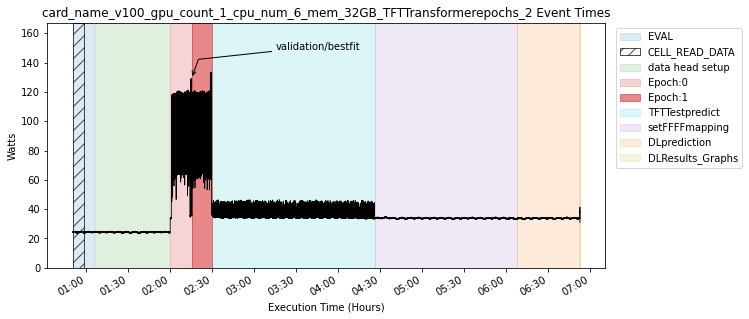

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


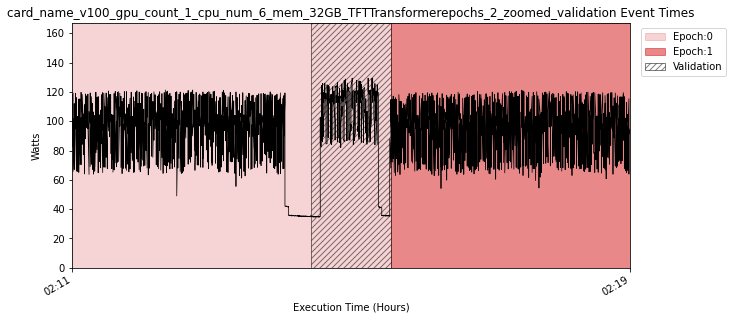

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,


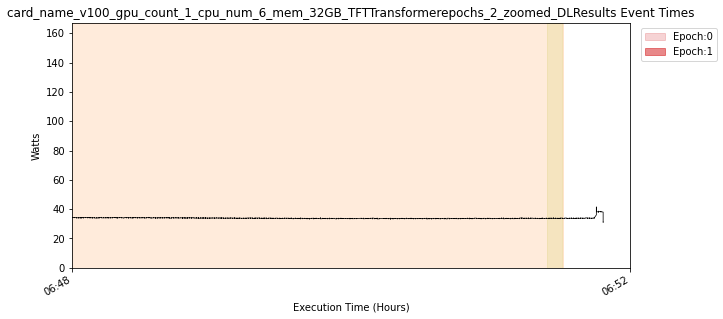

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,


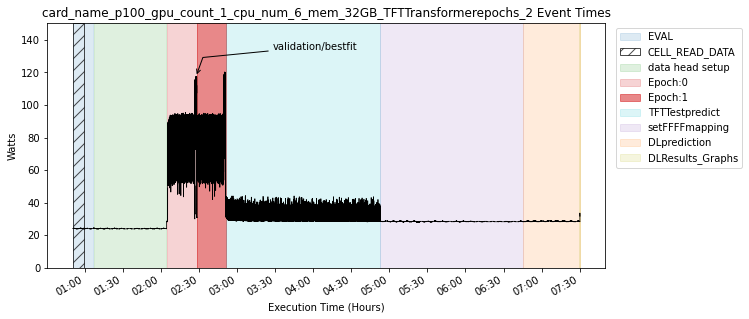

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


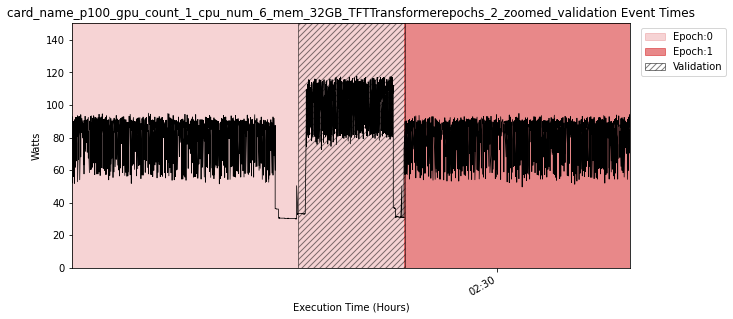

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,


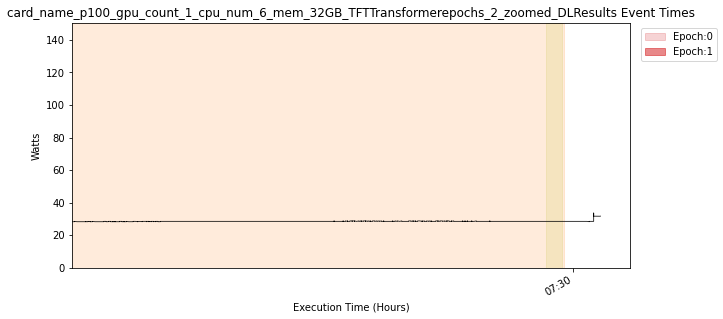

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,


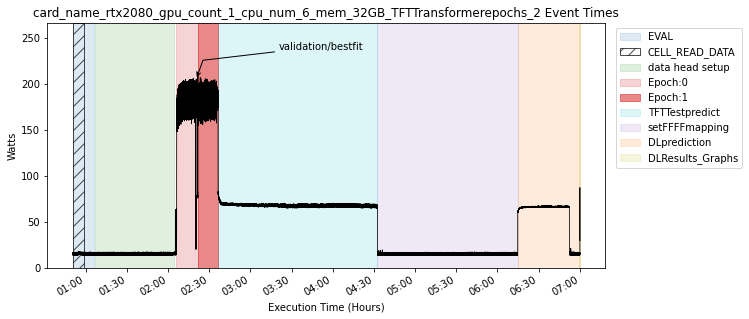

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


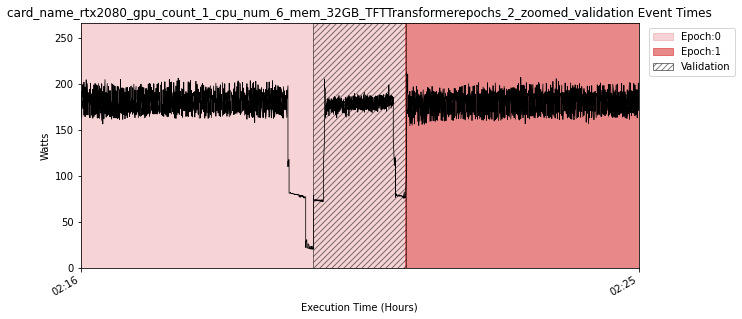

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,


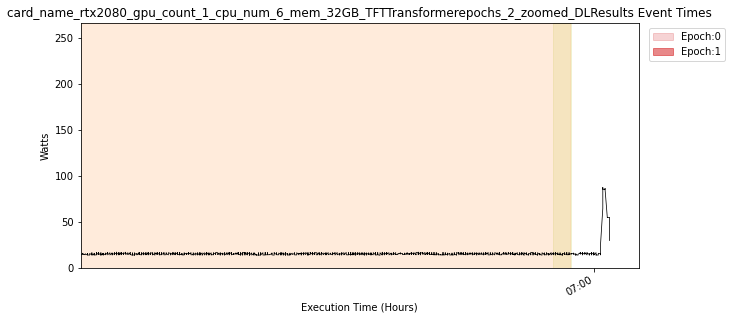

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,


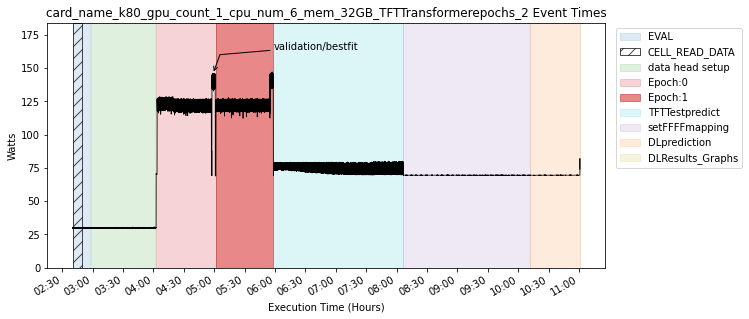

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


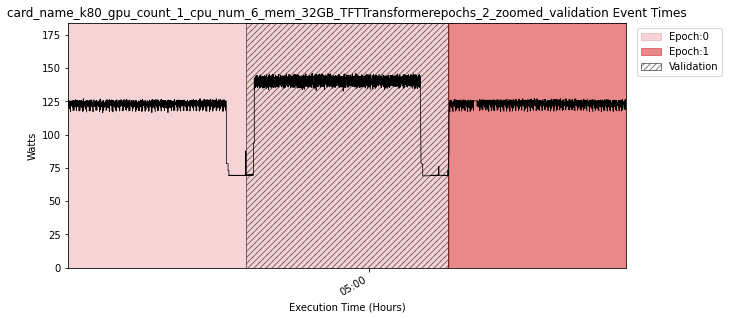

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,


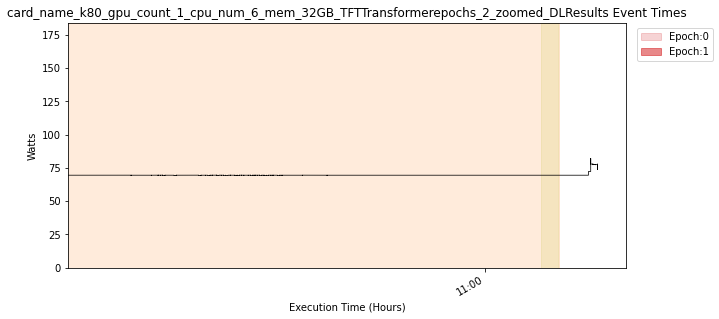

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,


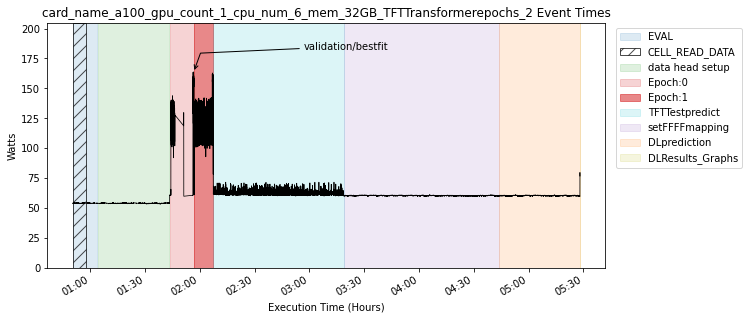

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


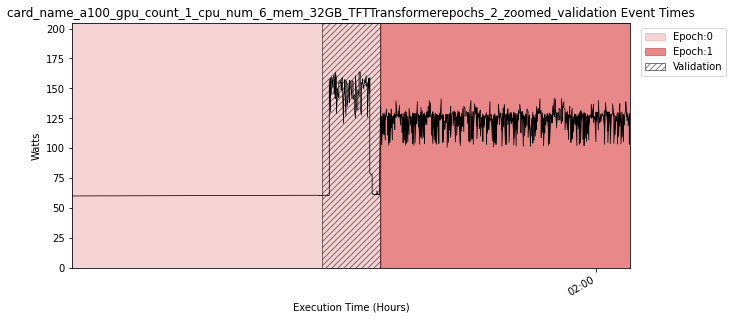

<ipython-input-49-b9f82e0e9b9c>:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time,


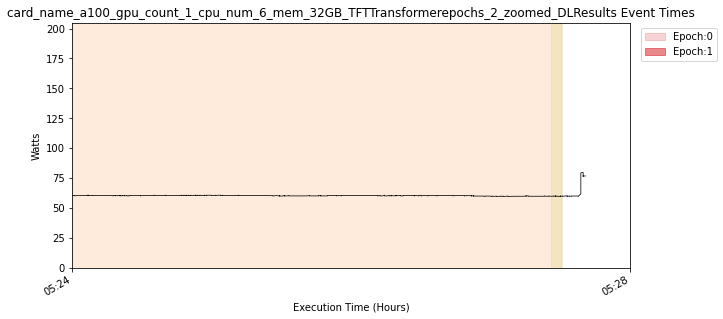

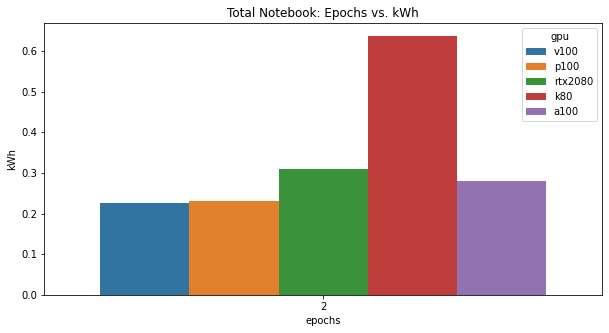

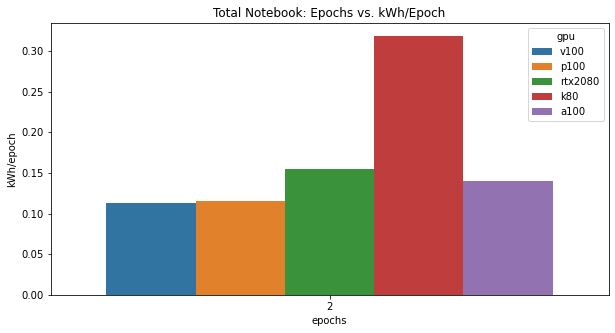

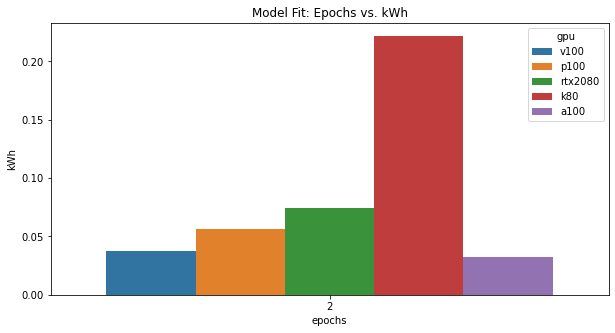

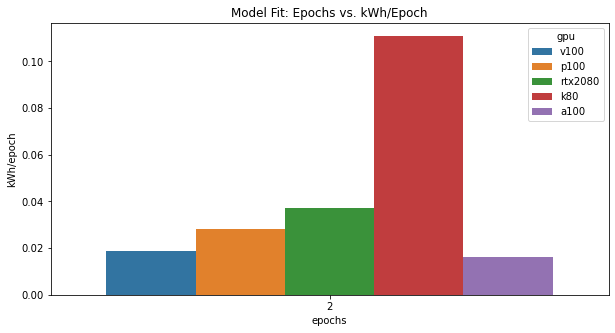

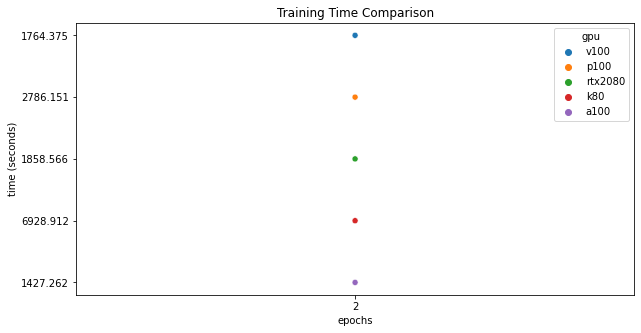

<Figure size 720x360 with 0 Axes>

In [51]:
power_df = pd.DataFrame()
for experiment in loaded_dict.keys():
        path = loaded_dict[experiment]['run_info']['path']
        epochs = loaded_dict[experiment]['run_info']['epochs']
        dir_path = path.rsplit('/',1)[0]
        plot_path = os.path.join(dir_path,'analysis')
        if not os.path.exists(plot_path):
            os.mkdir(plot_path)
        timer_df = loaded_dict[experiment]['timer_df']
        gpu_df = loaded_dict[experiment]['gpu_df']
        gpu_df['time'] = pd.to_datetime(gpu_df['time'].str.split(".").str[0],format='%Y-%m-%d:%H:%M:%S')
        plot_gpu_events(timer_df, gpu_df, epochs, experiment, plot_path)
        plot_gpu_events(timer_df, gpu_df, epochs, experiment, plot_path, 'validation')
        plot_gpu_events(timer_df, gpu_df, epochs, experiment, plot_path, 'DLResults')
        power_data = get_power_data(loaded_dict[experiment])
        power_df = pd.concat([power_df,power_data])

plot_power_usage(power_df, plot_path)
plot_train_times(loaded_dict, plot_path)